In [1]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

Altri test: least-square fitting, grafo pesato, phase-type distribution (con loss dipendente dai momenti)

Framework per profilazione: Cprofile
Settare numero massimo di core a 1, settare random_seed, macchina dedicata.

### Test 1
``` a = gm([1.], [_mean], [1.]); ```


Genero sample da $\mathcal{N}(10,1)$

In [2]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim1.soga')
cfg = produce_cfg(compiledFile)

In [3]:
pars = {'mean':5.}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [4]:
output_dist = start_SOGA(cfg, params_dict)

In [5]:
output_dist

Dist<['a'],pi: tensor([[1.]])
mu: tensor([[5.]], grad_fn=<IndexBackward0>)
sigma: tensor([[[1.]]])>

In [6]:
sampling_mean = torch.tensor(10.)
sampling_std = torch.tensor(1.)
samples = distributions.Normal(sampling_mean, sampling_std).sample((100,1))

In [7]:
def neg_likelihood(dist, samples, idx=0):
    likelihood = dist.gm.marg_pdf(samples,idx)
    log_likelihood = torch.log(likelihood)
    return -torch.sum(log_likelihood)

In [8]:
import torch

# Define the optimizer with init_mean as the parameter

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.05)

for i in range(500):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    #current_dist = compute_posterior(init_mean)
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 50 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


mean: 5.050000190734863 loss: 1336.25390625
mean: 7.3510422706604 loss: 469.444580078125
mean: 8.873242378234863 loss: 188.57070922851562
mean: 9.599806785583496 loss: 137.93829345703125
mean: 9.842803001403809 loss: 133.2074432373047
mean: 9.897483825683594 loss: 132.99913024902344
mean: 9.905135154724121 loss: 132.99551391601562
mean: 9.9056396484375 loss: 132.99549865722656
mean: 9.905638694763184 loss: 132.9954833984375
mean: 9.905637741088867 loss: 132.99549865722656


In [9]:
sampling_mean

tensor(10.)

In [10]:
sampling_dist = Dist(['x'], GaussianMix(torch.tensor([[1.]]), torch.tensor([[sampling_mean.item()]]), torch.tensor([[[sampling_std.item()]]])))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples))

Likelihood with respect to the sampling distribution:  tensor(133.4408)
Likelihood in the optimized distribution:  tensor(132.9955, grad_fn=<NegBackward0>)


### Test 2

``` a = gm([1.], [10.], [_std]);  ```

In [11]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim2.soga')
cfg = produce_cfg(compiledFile)

In [12]:
pars = {'std':2.}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [13]:
output_dist = start_SOGA(cfg, params_dict)

In [14]:
output_dist

Dist<['a'],pi: tensor([[1.]])
mu: tensor([[10.]])
sigma: tensor([[[4.]]], grad_fn=<IndexBackward0>)>

In [15]:
sampling_mean = torch.tensor(10.)
sampling_std = torch.tensor(1.)
samples = distributions.Normal(sampling_mean, sampling_std).sample((1000,1))
print('samples std', torch.std(samples))

samples std tensor(0.9743)


In [16]:
import torch

# Define the optimizer with init_mean as the parameter

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.01)

for i in range(500):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    #current_dist = compute_posterior(init_mean)
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 50 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


std: 1.9900000095367432 loss: 1730.669677734375
std: 1.4877179861068726 loss: 1534.3377685546875
std: 1.0524271726608276 loss: 1399.1395263671875
std: 0.9691246747970581 loss: 1392.622314453125
std: 0.9741334319114685 loss: 1392.592041015625
std: 0.9740184545516968 loss: 1392.5919189453125
std: 0.973995566368103 loss: 1392.5919189453125
std: 0.9739974141120911 loss: 1392.5919189453125
std: 0.9739974141120911 loss: 1392.5919189453125
std: 0.9739974141120911 loss: 1392.5919189453125


In [17]:
sampling_dist = Dist(['x'], GaussianMix(torch.tensor([1.]), torch.tensor([[sampling_mean.item()]]), torch.tensor([[[sampling_std.item()**2]]])))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples))

Likelihood with respect to the sampling distribution:  tensor(1393.2739)
Likelihood in the optimized distribution:  tensor(1392.5919, grad_fn=<NegBackward0>)


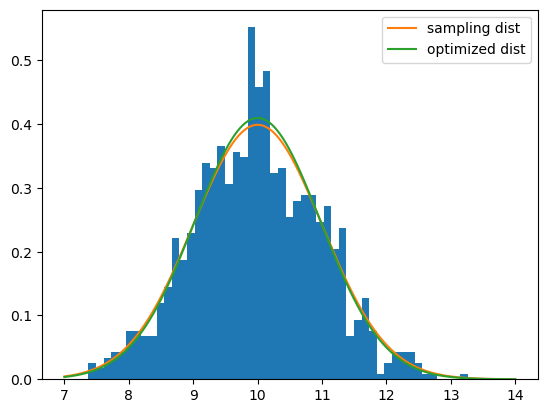

In [18]:
import matplotlib.pyplot as plt
from scipy.stats import norm

npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

x = np.linspace(7,14,500)
y_sampling = norm(sampling_mean.item(), sampling_std.item()).pdf(x)
y_optim = norm(sampling_mean.item(), params_dict['std'].item()).pdf(x)

plt.plot(x, y_sampling, label='sampling dist')
plt.plot(x, y_optim, label='optimized dist')
plt.legend()

### TEST 3

```
a = gm([1.], [1.], [1.]);
a = _par1 * a + 1.;
```

sample from the program with _par1 = 2

In [19]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

In [20]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim3.soga')
cfg = produce_cfg(compiledFile)

In [21]:
pars = {'par1':1.}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [22]:
output_dist = start_SOGA(cfg, params_dict)

In [23]:
output_dist

Dist<['a'],pi: tensor([[1.]])
mu: tensor([[1.]], grad_fn=<IndexBackward0>)
sigma: tensor([[[1.]]], grad_fn=<IndexBackward0>)>

In [24]:
sampling_mean = torch.tensor(2.)
sampling_std = torch.tensor(2.)
samples = distributions.Normal(sampling_mean, sampling_std).sample((1000,1))

In [25]:
torch.var(samples)

tensor(3.9444)

In [26]:
def neg_likelihood(dist, samples, idx=0):
    likelihood = dist.gm.marg_pdf(samples,idx)
    log_likelihood = torch.log(likelihood)
    return -torch.sum(log_likelihood)

In [27]:
import torch

# Define the optimizer with init_mean as the parameter

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.01)

for i in range(500):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    #current_dist = compute_posterior(init_mean)
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 50 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


par1: 1.0099999904632568 loss: 3517.9287109375
par1: 1.4080352783203125 loss: 2390.25341796875
par1: 1.6150457859039307 loss: 2204.60986328125
par1: 1.743518590927124 loss: 2147.13671875
par1: 1.8314465284347534 loss: 2124.253173828125
par1: 1.8934556245803833 loss: 2114.261962890625
par1: 1.937502145767212 loss: 2109.7431640625
par1: 1.9686485528945923 loss: 2107.688232421875
par1: 1.9904080629348755 loss: 2106.7666015625
par1: 2.0053436756134033 loss: 2106.364501953125


In [28]:
sampling_dist = Dist(['x'], GaussianMix(torch.tensor([1.]), torch.tensor([[sampling_mean.item()]]), torch.tensor([[[sampling_std.item()**2]]])))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples))

Likelihood with respect to the sampling distribution:  tensor(2106.4802)
Likelihood in the optimized distribution:  tensor(2106.1953, grad_fn=<NegBackward0>)


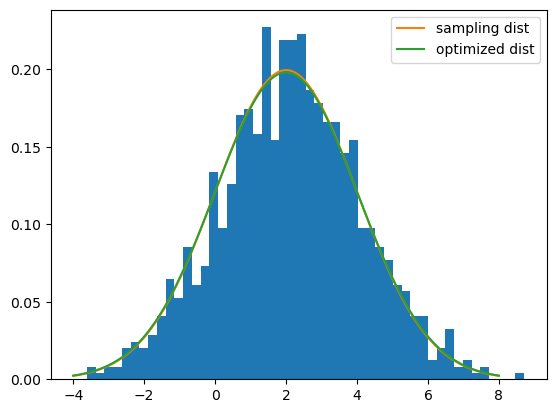

In [29]:
import matplotlib.pyplot as plt
from scipy.stats import norm

npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

x = np.linspace(-4,8,500)
y_sampling = norm(sampling_mean.item(), sampling_std.item()).pdf(x)
y_optim = norm(sampling_mean.item(), np.sqrt(output_dist.gm.sigma[0][0,0].item())).pdf(x)

plt.plot(x, y_sampling, label='sampling dist')
plt.plot(x, y_optim, label='optimized dist')
plt.legend()

### TEST 4

```
a = gm([1.], [1.], [1.]);
a = 2 * a + _par2;
```

sample from the program with _par2 = 1

In [30]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

In [31]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim4.soga')
cfg = produce_cfg(compiledFile)

In [32]:
pars = {'par2':2.}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [33]:
output_dist = start_SOGA(cfg, params_dict)

In [34]:
output_dist

Dist<['a'],pi: tensor([[1.]])
mu: tensor([[4.]], grad_fn=<IndexBackward0>)
sigma: tensor([[[4.]]])>

In [35]:
sampling_mean = torch.tensor(3.)
sampling_std = torch.tensor(2.)
samples = distributions.Normal(sampling_mean, sampling_std).sample((1000,1))

In [36]:
torch.var(samples)

tensor(3.9578)

In [37]:
import torch

# Define the optimizer with init_mean as the parameter

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.001)

for i in range(500):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    #current_dist = compute_posterior(init_mean)
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 50 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


par2: 1.9989999532699585 loss: 2220.98291015625
par2: 1.9493367671966553 loss: 2209.395751953125
par2: 1.9008666276931763 loss: 2198.6796875
par2: 1.853739619255066 loss: 2188.823974609375
par2: 1.8079720735549927 loss: 2179.78466796875
par2: 1.7635784149169922 loss: 2171.51708984375
par2: 1.720572590827942 loss: 2163.978515625
par2: 1.6789679527282715 loss: 2157.125732421875
par2: 1.6387780904769897 loss: 2150.91748046875
par2: 1.6000155210494995 loss: 2145.312255859375


In [38]:
sampling_dist = Dist(['x'], GaussianMix(torch.tensor([1.]), torch.tensor([[sampling_mean.item()]]), torch.tensor([[[sampling_std.item()**2]]])))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples))

Likelihood with respect to the sampling distribution:  tensor(2106.5356)
Likelihood in the optimized distribution:  tensor(2140.2710, grad_fn=<NegBackward0>)


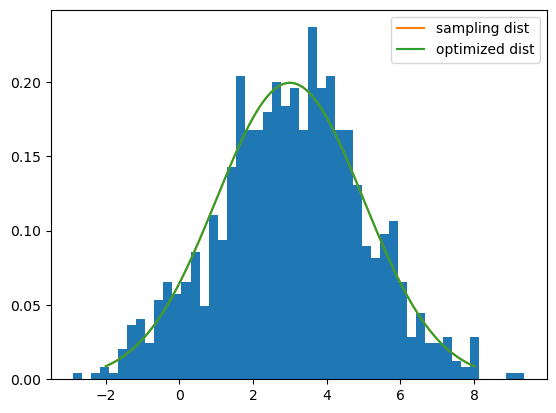

In [39]:
import matplotlib.pyplot as plt
from scipy.stats import norm

npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

x = np.linspace(-2,8,500)
y_sampling = norm(sampling_mean.item(), sampling_std.item()).pdf(x)
y_optim = norm(sampling_mean.item(), np.sqrt(output_dist.gm.sigma[0][0,0].item())).pdf(x)

plt.plot(x, y_sampling, label='sampling dist')
plt.plot(x, y_optim, label='optimized dist')
plt.legend()

### TEST 5

``` 
if gm([1.], [_mean], [1.]) < 0 {
    a = gm([1.], [-5.], [1.]);
} else {
    a = gm([1.], [5.], [1.]);
} end if;
```

sample from the program with _mean = 0

In [40]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

In [41]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim5.soga')
cfg = produce_cfg(compiledFile)

In [42]:
cfg.node_list

{'entry': EntryNode<>,
 'test0': TestNode<test0,gm([1.],[_mean],[1.])<0>,
 'state0': StateNode<state0,True,a=gm([1.],[-5.],[1.])>,
 'state1': StateNode<state1,False,a=gm([1.],[5.],[1.])>,
 'merge0': MergeNode<merge0>,
 'exit': ExitNode<>}

In [43]:
pars = {'mean':0.5}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [44]:
output_dist = start_SOGA(cfg, params_dict)

In [45]:
output_dist

Dist<['a'],pi: tensor([[0.3085],
        [0.6915]], grad_fn=<DivBackward0>)
mu: tensor([[-5.],
        [ 5.]], grad_fn=<IndexBackward0>)
sigma: tensor([[[1.]],

        [[1.]]], grad_fn=<IndexBackward0>)>

In [46]:
sampling_pi = torch.tensor(0.5)
sampling_mean = torch.tensor(3.)
sampling_std = torch.tensor(2.)

samples = torch.zeros((500,1))
latent = distributions.Bernoulli(sampling_pi).sample(samples.shape)
for i, r in enumerate(latent):
    if r:
        samples[i] = distributions.Normal(torch.tensor(-5.), torch.tensor(1.)).sample((1,))
    else:
        samples[i] = distributions.Normal(torch.tensor(5.), torch.tensor(1.)).sample((1,))

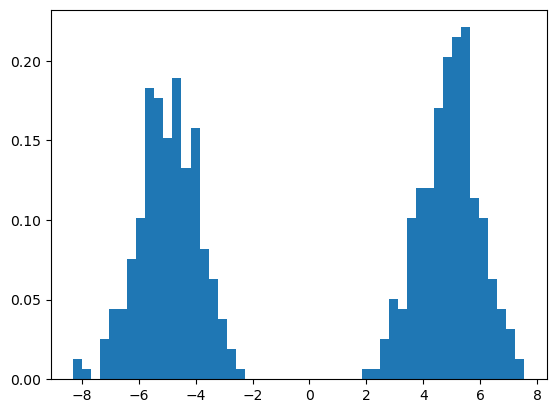

In [47]:
import matplotlib.pyplot as plt
from scipy.stats import norm

npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

In [48]:
def neg_likelihood(dist, samples, idx=0):
    likelihood = dist.gm.marg_pdf(samples,idx)
    log_likelihood = torch.log(likelihood)
    return -torch.sum(log_likelihood)

In [49]:
import torch

#pars = {'mean':2.}
#
## creates torch parameters for each params declared in the dictionary
#params_dict = {}
#for key, value in pars.items():
#    params_dict[key] = torch.tensor(value, requires_grad=True)    

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.01)

for i in range(300):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)

    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 30 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


mean: 0.49000000953674316 loss: 1106.6004638671875
mean: 0.2160041779279709 loss: 1079.8514404296875
mean: 0.0708356574177742 loss: 1075.4034423828125
mean: 0.04882190003991127 loss: 1075.358642578125
mean: 0.05484754964709282 loss: 1075.3519287109375
mean: 0.05547766387462616 loss: 1075.35205078125
mean: 0.05512605234980583 loss: 1075.3519287109375
mean: 0.0551738478243351 loss: 1075.3519287109375
mean: 0.05517559126019478 loss: 1075.3519287109375
mean: 0.055173274129629135 loss: 1075.3519287109375


In [50]:
current_dist

Dist<['a'],pi: tensor([[0.4780],
        [0.5220]], grad_fn=<DivBackward0>)
mu: tensor([[-5.],
        [ 5.]], grad_fn=<IndexBackward0>)
sigma: tensor([[[1.]],

        [[1.]]], grad_fn=<IndexBackward0>)>

In [51]:
sampling_dist = Dist(['x'], GaussianMix(torch.tensor([[0.5], [0.5]]), torch.tensor([[-5.], [5.]]), torch.tensor([[[1.]], [[1.]]])))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples, idx=0))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples, idx=0))

Likelihood with respect to the sampling distribution:  tensor(1075.8361)
Likelihood in the optimized distribution:  tensor(1075.3521, grad_fn=<NegBackward0>)


In [52]:
output_dist

Dist<['a'],pi: tensor([[0.4780],
        [0.5220]], grad_fn=<DivBackward0>)
mu: tensor([[-5.],
        [ 5.]], grad_fn=<IndexBackward0>)
sigma: tensor([[[1.]],

        [[1.]]], grad_fn=<IndexBackward0>)>

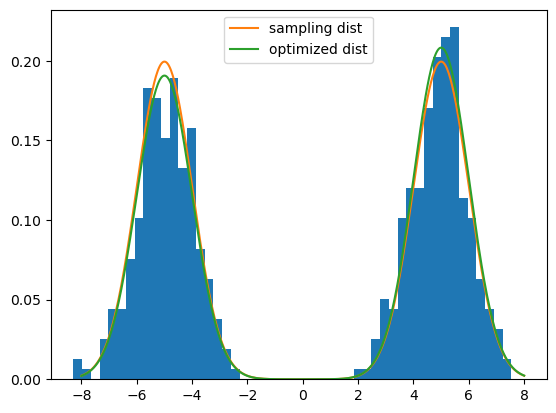

In [53]:
import matplotlib.pyplot as plt
from scipy.stats import norm


npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

x = torch.linspace(-8,8,500).view(-1,1)
y_sampling = sampling_dist.gm.marg_pdf(x, 0)
y_optim = output_dist.gm.marg_pdf(x, 0).detach()

plt.plot(x, y_sampling, label='sampling dist')
plt.plot(x, y_optim, label='optimized dist')
plt.legend()

### TEST 6

``` 
if gm([1.], [0.], [1.]) < _coeff {
    a = gm([1.], [-5.], [1.]);
} else {
    a = gm([1.], [5.], [1.]);
} end if;
```

sample from the program with _coeff = 0

In [54]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

In [55]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim6.soga')
cfg = produce_cfg(compiledFile)

In [56]:
pars = {'coeff':0.5}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [57]:
output_dist = start_SOGA(cfg, params_dict)

In [58]:
output_dist

Dist<['a'],pi: tensor([[0.6915],
        [0.3085]], grad_fn=<DivBackward0>)
mu: tensor([[-5.],
        [ 5.]], grad_fn=<IndexBackward0>)
sigma: tensor([[[1.]],

        [[1.]]], grad_fn=<IndexBackward0>)>

In [59]:
sampling_pi = torch.tensor(0.5)
sampling_mean = torch.tensor(3.)
sampling_std = torch.tensor(2.)

samples = torch.zeros((500,1))
latent = distributions.Bernoulli(sampling_pi).sample(samples.shape)
for i, r in enumerate(latent):
    if r:
        samples[i] = distributions.Normal(torch.tensor(-5.), torch.tensor(1.)).sample((1,))
    else:
        samples[i] = distributions.Normal(torch.tensor(5.), torch.tensor(1.)).sample((1,))

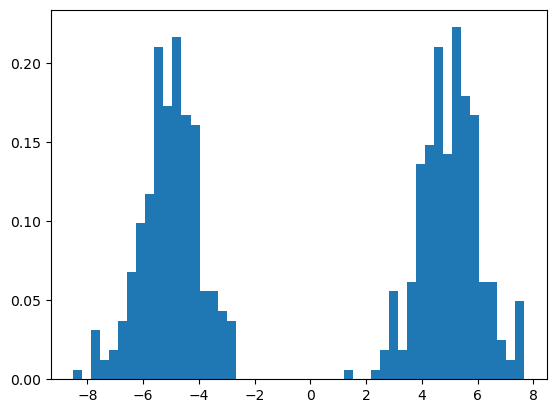

In [60]:
import matplotlib.pyplot as plt
from scipy.stats import norm

npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

In [61]:
import torch

#pars = {'mean':2.}
#
## creates torch parameters for each params declared in the dictionary
#params_dict = {}
#for key, value in pars.items():
#    params_dict[key] = torch.tensor(value, requires_grad=True)    

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.01)

for i in range(300):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 30 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


coeff: 0.49000000953674316 loss: 1123.1064453125
coeff: 0.2106243073940277 loss: 1088.3297119140625
coeff: 0.03308523818850517 loss: 1079.193603515625
coeff: -0.027221061289310455 loss: 1078.48193359375
coeff: -0.03259784355759621 loss: 1078.48095703125
coeff: -0.030283810570836067 loss: 1078.479736328125
coeff: -0.02996964007616043 loss: 1078.4798583984375
coeff: -0.030086956918239594 loss: 1078.4798583984375
coeff: -0.030088361352682114 loss: 1078.4798583984375
coeff: -0.030083144083619118 loss: 1078.4798583984375


In [62]:
sampling_dist = Dist(['x'], GaussianMix(torch.tensor([[0.5], [0.5]]), torch.tensor([[-5.], [5.]]), torch.tensor([[[1.]], [[1.]]])))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples, idx=0))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples, idx=0))

Likelihood with respect to the sampling distribution:  tensor(1078.6238)
Likelihood in the optimized distribution:  tensor(1078.4799, grad_fn=<NegBackward0>)


In [63]:
output_dist

Dist<['a'],pi: tensor([[0.4880],
        [0.5120]], grad_fn=<DivBackward0>)
mu: tensor([[-5.],
        [ 5.]], grad_fn=<IndexBackward0>)
sigma: tensor([[[1.]],

        [[1.]]], grad_fn=<IndexBackward0>)>

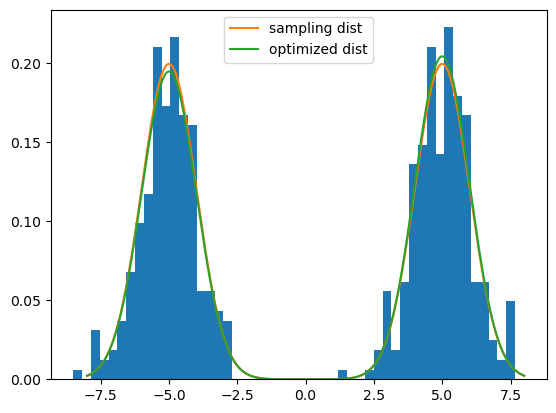

In [64]:
import matplotlib.pyplot as plt
from scipy.stats import norm


npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

x = torch.linspace(-8,8,500).view(-1,1)
y_sampling = sampling_dist.gm.marg_pdf(x, 0)
y_optim = output_dist.gm.marg_pdf(x, 0).detach()

plt.plot(x, y_sampling, label='sampling dist')
plt.plot(x, y_optim, label='optimized dist')
plt.legend()

### TEST 7

``` 
a = gm([1.], [_mean], [_std]); 
```

In [65]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

In [66]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim7.soga')
cfg = produce_cfg(compiledFile)

In [67]:
pars = {'mean':5., 'std':2.5}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [68]:
output_dist = start_SOGA(cfg, params_dict)

In [69]:
output_dist

Dist<['a'],pi: tensor([[1.]])
mu: tensor([[5.]], grad_fn=<IndexBackward0>)
sigma: tensor([[[6.2500]]], grad_fn=<IndexBackward0>)>

In [70]:
sampling_mean = torch.tensor(10.)
sampling_std = torch.tensor(1.)
samples = distributions.Normal(sampling_mean, sampling_std).sample((1000,1))
print('samples std', torch.std(samples))

samples std tensor(0.9902)


In [71]:
import torch

# Define the optimizer with init_mean as the parameter

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.01)

for i in range(1000):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    #current_dist = compute_posterior(init_mean)
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 100 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


mean: 5.010000228881836std: 2.509999990463257 loss: 3914.041015625
mean: 5.880712032318115std: 3.221547842025757 loss: 2957.63525390625
mean: 6.569808006286621std: 3.450908660888672 loss: 2694.76708984375
mean: 7.20113468170166std: 3.3972325325012207 loss: 2525.4775390625
mean: 7.8260626792907715std: 3.1076228618621826 loss: 2350.284423828125
mean: 8.485264778137207std: 2.5718820095062256 loss: 2114.08544921875
mean: 9.230392456054688std: 1.7394976615905762 loss: 1737.1806640625
mean: 9.942666053771973std: 0.9861669540405273 loss: 1410.52294921875
mean: 10.000844955444336std: 0.9896543622016907 loss: 1408.5931396484375
mean: 10.0005521774292std: 0.9897081255912781 loss: 1408.5931396484375


In [72]:
sampling_dist = Dist(['x'], GaussianMix(torch.tensor([[1.]]), torch.tensor([[sampling_mean.item()]]), torch.tensor([[[sampling_std.item()**2]]])))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples))

Likelihood with respect to the sampling distribution:  tensor(1408.6995)
Likelihood in the optimized distribution:  tensor(1408.5931, grad_fn=<NegBackward0>)


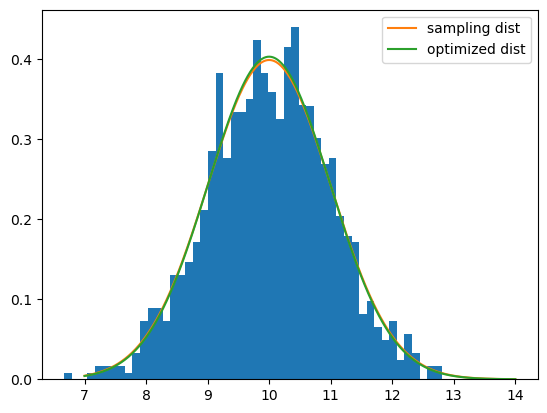

In [73]:
import matplotlib.pyplot as plt
from scipy.stats import norm

npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

x = torch.linspace(7,14,500).view(-1,1)
y_sampling = norm(sampling_mean.item(), sampling_std.item()).pdf(x)
y_optim = norm(sampling_mean.item(), params_dict['std'].item()).pdf(x)

plt.plot(x, y_sampling, label='sampling dist')
plt.plot(x, y_optim, label='optimized dist')
plt.legend()

# Runtimes on old benchmarks

In [1]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *
from time import time

In [2]:
compiledFile=compile2SOGA('../programs/SOGA/Scalability/TrueSkills5.soga')
cfg = produce_cfg(compiledFile)

times = []

for i in range(100):
    start = time()
    output_dist = start_SOGA(cfg, {})
    end = time()
    times.append(end-start)

np.mean(times)

0.04083165884017945

In [3]:
compiledFile=compile2SOGA('../programs/SOGA/Scalability/TrueSkills10.soga')
cfg = produce_cfg(compiledFile)

times = []

for i in range(100):
    start = time()
    output_dist = start_SOGA(cfg, {})
    end = time()
    times.append(end-start)

np.mean(times)

0.059299399852752684

In [4]:
compiledFile=compile2SOGA('../programs/SOGA/Scalability/TrueSkills20.soga')
cfg = produce_cfg(compiledFile)

times = []

for i in range(100):
    start = time()
    output_dist = start_SOGA(cfg, {})
    end = time()
    times.append(end-start)

np.mean(times)

0.19232213258743286

In [5]:
compiledFile=compile2SOGA('../programs/SOGA/Scalability/TrueSkills30.soga')
cfg = produce_cfg(compiledFile)

times = []

for i in range(100):
    start = time()
    output_dist = start_SOGA(cfg, {})
    end = time()
    times.append(end-start)

np.mean(times)

0.2792282724380493

In [7]:
compiledFile=compile2SOGA('../programs/SOGA/Scalability/TrueSkills50.soga')
cfg = produce_cfg(compiledFile)

times = []

for i in range(100):
    start = time()
    output_dist = start_SOGA(cfg, {})
    end = time()
    times.append(end-start)

np.mean(times)

0.33835127830505374